# Searching Efficient Models for Human Activity Recognition

## Import Libraries


In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPooling1D, Conv1D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
import tensorflow.keras as tfkeras
import tensorflow as tf
from numpy.linalg import svd
from sklearn import metrics
from sklearn import svm
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn import discriminant_analysis
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import shuffle
import requests
import io
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import numpy as np
import pandas as pd
import random
from time import process_time

import matplotlib.pyplot as plt
%matplotlib inline
# style.use('ggplot')


TRAIN_URL = "https://drive.google.com/uc?export=download&id=16q7ZkNOSHgJ6TtEg4ngQ_MtBoC824ByN"
TEST_URL = "https://drive.google.com/uc?export=download&id=1Nd9GZT6cvx0KHEhg0bDt6VnF6picYlED"


## Dataset Loading


In [ ]:
train_data_raw = requests.get(TRAIN_URL).content
train_data = shuffle(pd.read_csv(io.StringIO(train_data_raw.decode("utf-8"))))
train_data.head()


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
1227,0.297211,-0.017292,-0.126027,-0.979895,-0.938981,-0.932213,-0.982511,-0.948454,-0.933149,-0.922238,-0.493754,-0.794507,0.814799,0.653797,0.790841,-0.955994,-0.999635,-0.999059,-0.996564,-0.985422,-0.969045,-0.933645,-0.068400,-0.365879,-0.453322,-0.057310,0.113563,0.023048,-0.046523,0.282171,-0.017074,0.190877,0.106908,0.003823,0.047744,0.125700,-0.309299,0.299985,-0.163286,-0.270675,...,-0.723642,-0.968254,0.130842,-0.583624,-0.869369,-0.951443,-0.969146,-0.961678,-0.973536,-0.984379,-0.951443,-0.998917,-0.949041,-0.404941,-0.948718,0.328305,-0.731125,-0.887882,-0.957039,-0.959725,-0.952433,-0.967988,-0.993444,-0.957039,-0.998951,-0.953193,-0.446142,-0.968254,0.157736,-0.466658,-0.805001,0.062670,-0.465639,-0.046481,-0.385848,0.606540,-0.945677,-0.043047,6,LAYING
2642,0.273069,-0.024877,-0.143134,-0.300489,0.156014,-0.465204,-0.336041,0.162381,-0.485705,-0.040346,-0.080098,-0.233573,0.198671,-0.126900,0.550968,-0.164812,-0.754024,-0.742071,-0.866411,-0.438327,-0.049496,-0.503848,0.463044,0.291607,0.074548,-0.336215,0.206017,-0.115245,0.321478,-0.105973,0.090717,0.155694,0.074966,-0.130889,0.124912,-0.049315,0.129936,-0.273780,0.213900,0.383913,...,0.276199,-0.904762,-0.001476,-0.256185,-0.661865,-0.559326,-0.504782,-0.478096,-0.643461,-0.972509,-0.559326,-0.859268,-0.554612,0.412857,-0.384615,-0.062519,-0.349276,-0.740399,-0.663941,-0.651165,-0.607945,-0.707008,-0.821907,-0.663941,-0.937013,-0.577482,0.287610,-0.904762,0.022850,-0.262694,-0.667553,0.057840,0.582541,0.635082,0.304295,-0.767893,0.247557,-0.042239,15,WALKING
5056,0.300649,-0.053415,-0.130268,-0.179767,0.272008,0.072779,-0.237588,0.196398,0.139355,-0.028184,0.244915,-0.032918,-0.111757,-0.027269,0.245668,0.084356,-0.662308,-0.685964,-0.484664,-0.387999,-0.090117,0.098286,0.511089,0.015663,0.131310,-0.442620,0.401750,-0.347244,0.302680,-0.215794,0.150598,0.099644,-0.123572,-0.403896,0.355007,-0.068722,-0.231966,-0.171964,-0.257653,0.186670,...,0.473667,-0.904762,0.074681,-0.315218,-0.675217,-0.007939,0.159669,0.140941,0.102459,-0.894510,-0.007939,-0.253528,-0.125782,0.746743,-1

In [ ]:
test_data_raw = requests.get(TEST_URL).content
test_data = shuffle(pd.read_csv(io.StringIO(test_data_raw.decode("utf-8"))))
test_data.head()


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
617,0.218948,-0.050102,-0.123121,-0.153430,-0.070759,-0.343636,-0.267701,-0.130136,-0.347031,0.083637,-0.130233,-0.365317,0.049962,0.089765,0.523334,-0.163580,-0.639814,-0.830751,-0.803318,-0.426444,-0.372878,-0.449998,0.322562,0.151432,-0.140082,-0.207233,0.050741,0.048559,0.170647,-0.083813,0.104283,0.129571,0.097189,-0.266333,0.320689,-0.435321,0.219177,-0.261400,0.271137,-0.100012,...,0.325963,-0.904762,0.260138,-0.496273,-0.833307,-0.488247,-0.521720,-0.457770,-0.631618,-0.434025,-0.488247,-0.848722,-0.653006,0.362313,-0.897436,0.001518,-0.424002,-0.776097,-0.733177,-0.765527,-0.707924,-0.835044,-0.859910,-0.733177,-0.965256,-0.700959,0.251031,-0.746032,0.000408,-0.580429,-0.895979,0.270929,0.700387,0.928789,0.623540,-0.776845,0.240046,-0.044466,4,WALKING_UPSTAIRS
358,0.277317,-0.017056,-0.108521,-0.987081,-0.989408,-0.987652,-0.986827,-0.989570,-0.988083,-0.931455,-0.570653,-0.820825,0.846055,0.685616,0.837890,-0.988735,-0.999862,-0.999938,-0.999762,-0.986778,-0.990054,-0.988207,-0.398506,-0.646009,-0.550766,0.127993,-0.098158,0.049649,-0.194848,0.474900,-0.192682,0.250196,0.010980,0.222978,-0.067658,0.052597,-0.148735,0.133015,-0.606537,-0.193269,...,-1.000000,-0.650794,0.379367,-0.723745,-0.945502,-0.988271,-0.981723,-0.983060,-0.982103,-0.999540,-0.988271,-0.999788,-0.990143,-0.737609,-0.948718,-0.298940,-0.139742,-0.523873,-0.995621,-0.997553,-0.997238,-0.997649,-0.992569,-0.995621,-0.999982,-0.996642,-1.000000,-1.000000,0.478775,-0.691050,-0.869921,-0.026956,-0.279358,0.284624,0.414171,0.564388,-0.675673,-0.323858,4,LAYING
2357,0.209658,0.017829,-0.058918,0.185711,0.392352,-0.055059,0.165735,0.268732,-0.128464,0.526747,0.116696,-0.291688,0.101131,-0.204897,-0.021213,0.268817,-0.295913,-0.624877,-0.595480,0.048748,-0.207481,-0.234502,0.259698,0.547402,0.364350,-0.513781,0.274552,0.080002,-0.015148,0.117007,-0.147428,0.372547,-0.035500,0.046143,-0.139838,0.379986,-0.064820,-0.423443,-0.466809,0.476250,...,0.593006,-0.873016,-0.019582,0.322466,0.059515,-0.234529,-0.295638,-0.183007,-0.389461,-0.950739,-0.234529,-0.668765,-0.208923,0.6133

In [ ]:
# Splitting train features and labels
X_train = train_data.iloc[:, :-2]
y_train_string = train_data.iloc[:, -1]

X_test = test_data.iloc[:, :-2]
y_test_string = test_data.iloc[:, -1]


print('Shape of Train data : ', train_data.shape)
print('Shape of X_Train : ', X_train.shape)
print('Shape of Train class : ', y_train_string.shape)
print('Shape of Test data : ', test_data.shape)
print('Shape of X_test : ', X_test.shape)
print('Shape of Test class : ', y_test_string.shape)


Shape of Train data :  (7352, 563)
Shape of X_Train :  (7352, 561)
Shape of Train class :  (7352,)
Shape of Test data :  (2947, 563)
Shape of X_test :  (2947, 561)
Shape of Test class :  (2947,)


In [ ]:
# Processing the raw data with standard scalar
stdsc = StandardScaler()
X_train = stdsc.fit_transform(X_train)
X_test = stdsc.fit_transform(X_test)


## Data Variance Analysis and feature extraction


In [ ]:
labels = np.unique(y_train_string)
# labels


In [ ]:
encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train_string)
y_train_enc = pd.get_dummies(y_train).values
# y_train


In [ ]:
y_test = encoder.fit_transform(y_test_string)
y_test_enc = pd.get_dummies(y_test).values
# y_test


In [ ]:
label_counts = y_train_string.value_counts()
label_counts


LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: Activity, dtype: int64

In [ ]:
n = y_train_string.unique().shape[0]
colormap = get_cmap('tab10')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]
# colors


### Data visualisation with PCA


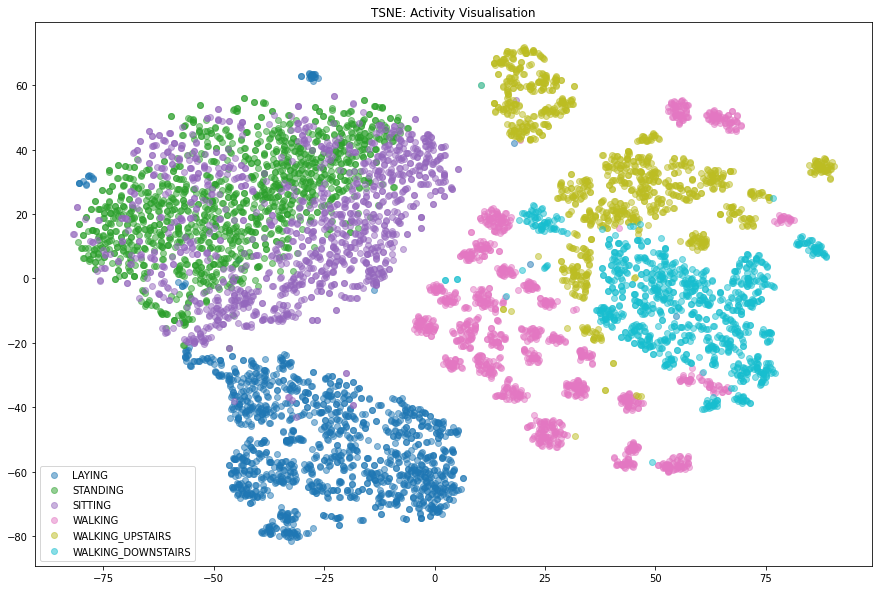

In [ ]:
pca = decomposition.PCA(n_components=0.9, random_state=3)
pca_fit = pca.fit(X_train)
X_train_pca = pca_fit.transform(X_train)

# Transform data
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(X_train_pca)

# Create subplots
fig, axarr = plt.subplots(1, 1, figsize=(15, 10))

# Plot each activity
for i, group in enumerate(label_counts.index):
    # Mask to separate sets
    mask = (y_train_string == group).values
    axarr.scatter(x=tsne_transformed[mask][:, 0], y=tsne_transformed[mask]
                  [:, 1], c=colors[i], alpha=0.5, label=group)
axarr.set_title('TSNE: Activity Visualisation')
axarr.legend()

plt.show()


The PCA plot shows that the features a almost separable. So, we can use linearly separable functions.

Now we will find the variance spread of data in the range of principal components


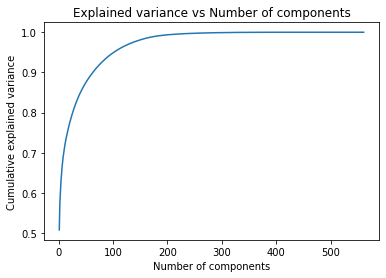

In [ ]:
pca_var = decomposition.PCA(n_components=561)
X_pca = pca_var.fit_transform(X_train)
var_explained = pca_var.explained_variance_ratio_

cumulative_variance = np.cumsum(var_explained)
x = np.array(range(1, 562))
plt.plot(x, cumulative_variance)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Explained variance vs Number of components")
plt.show()


In [ ]:
# Finding the resultant dimension of PCs
principal_components = 0
for item in cumulative_variance:
    if item <= 0.95:
        principal_components += 1
print("Resultant PCA at variance of 95% is: {}".format(principal_components + 1))


Resultant PCA at variance of 95% is: 102


We can infer that we can get most of the variance of data at 95% of variation spread, so we can reduce the dimension the dataset with first 102 Principal components in feature space.


### Data Visualisation with FLDA


In [ ]:
# Creating a FLDA encoder from scratch
class Fisher:
    def __init__(self, data, num_dim):
        '''
        Getting the data from csv file and number of dimensions that the data
        is to be reduces to.
        '''
        self.data = data
        self.num_dim = num_dim
        self.columnlabel = len(self.data[0])-1
        self.dim = self.columnlabel
        random.shuffle(self.data)
        self.training_data = self.data
        self.group_data_by_classes()
        self.calculate_means()
        self.calculate_SB_SW()

        self.eigvals = self.calculate_eigen_values()
        self.tf_data = self.transform_data()

    def group_data_by_classes(self):
        '''
        The data is grouped by classes ie target value of each column
        and also number of classes is stored
        '''
        self.grouped_data = {}
        for i in self.training_data:
            if i[self.columnlabel] in self.grouped_data:
                self.grouped_data[i[self.columnlabel]].append(
                    i[:self.columnlabel])
            else:
                self.grouped_data[i[self.columnlabel]] = [i[:self.columnlabel]]
        self.num_of_classes = len(self.grouped_data)

    def calculate_means(self):
        '''
        This calculates mean of data classwise and overall mean.
        '''
        self.class_mean = {}
        self.overall_mean = np.array([0. for x in range(self.dim)])
        for i in self.grouped_data:
            self.class_mean[i] = np.array([0. for x in range(self.dim)])
            for j in self.grouped_data[i]:
                for k in range(len(j)):
                    self.class_mean[i][k] += j[k]
                    self.overall_mean[k] += j[k]
        for i in self.class_mean:
            for j in range(len(self.class_mean[i])):
                self.class_mean[i][j] /= len(self.grouped_data[i])
        for i in range(len(self.overall_mean)):
            self.overall_mean[i] /= len(self.training_data)

    def calculate_SB_SW(self):
        '''
        This calculates SB and SW matrices by formula specified in the report
        and return the matrices which are used for data transformation
        '''
        self.SB = np.zeros((self.dim, self.dim))
        for i in self.class_mean:
            mk_minus_m = np.array([self.class_mean[i]-self.overall_mean])
            nk = len(self.grouped_data[i])
            mk_minus_m_t = mk_minus_m.transpose()
            temp = (mk_minus_m_t*nk).dot(mk_minus_m)
            self.SB += temp

        self.SW = np.zeros((self.dim, self.dim))
        for i in self.class_mean:
            mk = np.array(self.class_mean[i])
            for j in self.grouped_data[i]:
                xnk = np.array(j)
                xnk_minus_mk = np.array([xnk-mk])
                xnk_minus_mk_t = xnk_minus_mk.transpose()
                self.SW += xnk_minus_mk_t.dot(xnk_minus_mk)

    def calculate_eigen_values(self):
        '''
        This calculates eigenvalues and eigenvectors of the data and number of dimensions
        that data is to be reduced to and calculates vector w that is used for transforming data
        points.
        '''
        self.eigval = []
        mat = np.dot(np.linalg.pinv(self.SW), self.SB)
        self.eigval, eigvecs = np.linalg.eig(mat)
        eiglist = [(self.eigval[i], eigvecs[:, i])
                   for i in range(len(self.eigval))]
        eiglist = sorted(eiglist, key=lambda x: x[0], reverse=True)
        w = np.array([eiglist[i][1] for i in range(self.num_dim)])
        self.w = w
        return self.w

    def transform_data(self):
        '''
        This function transforms data to required number of dimensions and calculates threshold
        using gaussian normal equation by calculating mean and std deviation of all classes.
        '''
        self.arr = []
        self.arr_te = []

        self.transformed_grouped_data = {}
        for i in self.grouped_data:
            if i not in self.transformed_grouped_data:
                self.transformed_grouped_data[i] = []
            for j in self.grouped_data[i]:
                x = self.w.dot(j)
                self.transformed_grouped_data[i].append(np.real(x))
                temp_arr = []
                temp_arr.append(i)
                for k in range(self.num_dim):
                    temp_arr.append(np.real(x[k]))
                self.arr.append(temp_arr)
        return self.arr


temp_train = np.insert(X_train, 561, y_train, axis=1)
temp_train = temp_train.tolist()

FLDA = Fisher(temp_train, 5)
tf_data = FLDA.tf_data
# print(tf_data)


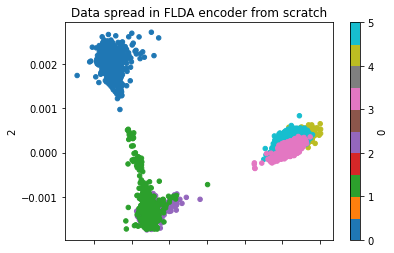

In [ ]:
# Plotting data encoded with FLDA created from scratch.
pd.DataFrame(tf_data).plot.scatter(x=1, y=2, c=0, colormap='tab10')
plt.title("Data spread in FLDA encoder from scratch")
plt.show()


In [ ]:
# levaraging the LDA function from sklearn library to make a FLDA encoder
lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=3)
tr_class = y_train[:, np.newaxis]
lda_fit = lda.fit(X_train, y_train)
X_train_lda = lda_fit.transform(X_train)
tfsk_df = pd.DataFrame(np.hstack((X_train_lda, tr_class)))
tfsk_df.head()


,0,1,2,3
0,-17.228614,12.669596,-0.043220,0.0
1,15.310842,0.880174,-6.885307,3.0
2,17.143827,1.709252,-0.747366,5.0
3,-9.587881,-6.479332,0.756705,2.0
4,15.246326,0.715740,6.386274,4.0


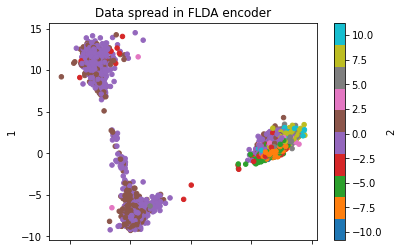

In [ ]:
pd.DataFrame(np.hstack((X_train_lda, tr_class))).plot.scatter(
    x=0, y=1, c=2, colormap='tab10')
plt.title("Data spread in FLDA encoder")
plt.show()


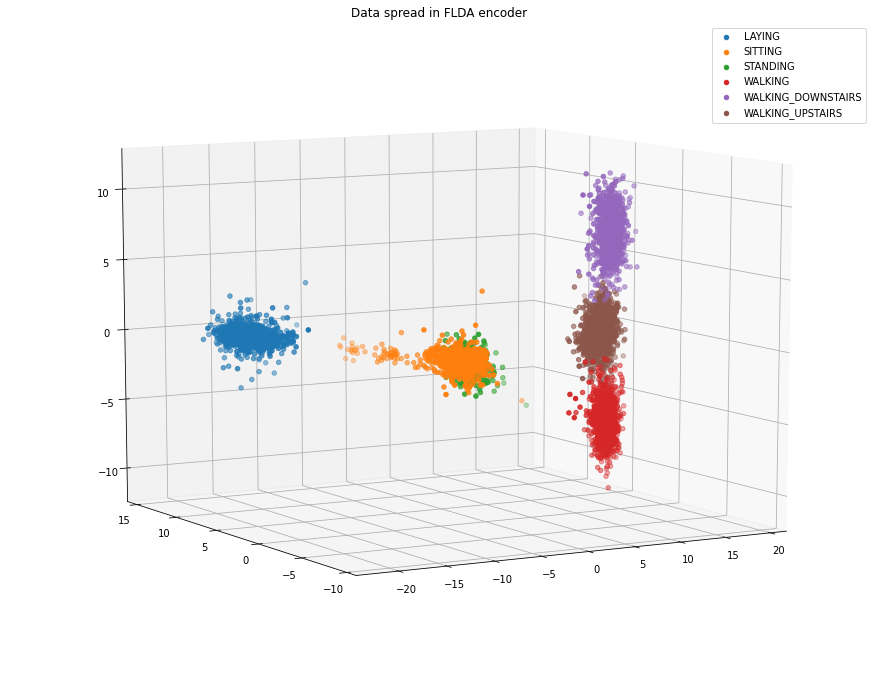

In [ ]:
fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)

for grp_name, grp_idx in tfsk_df.groupby(3).groups.items():
    y = tfsk_df.iloc[grp_idx, 1]
    x = tfsk_df.iloc[grp_idx, 0]
    z = tfsk_df.iloc[grp_idx, 2]
    # this way you can control color/marker/size of each group freely
    ax.scatter(x, y, z, label=labels[int(grp_name)])
    # ax.scatter(*tfsk_df.iloc[grp_idx, [0, 1, 2]].T.values, label=grp_name)  # if you want to do everything in one line, lol

ax.legend()
for ii in range(0, 360, 120):
    ax.view_init(elev=10.0, azim=ii)
    plt.savefig("moviesk%d.png" % ii, )

plt.title("Data spread in FLDA encoder")

# ax.legend()
plt.show()


From the above two plots we can oberserve that, the encoder leveraged from pre-defined library sklearn is more robust that FLDA encoder created from scratch. We will use this encoder for rest part of our project.


## Helper Functions


In [ ]:
def plot_confusion_matrix(cm, lables):
    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=lables, yticklabels=lables,
           ylabel='True label',
           xlabel='Predicted label')
    plt.xticks(rotation=90)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i, j]), ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()


## SVM Classification


### SVM Classification on Raw Data


*-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-*

 HAR data - SVM Classification on Raw Data

Training accuracy:  0.9857181703408759

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Total Time cost to process SVM model for Raw data: 19.39 sec
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.96      0.91      0.93       491
           2       0.92      0.96      0.94       532
           3       0.98      0.98      0.98       496
           4       0.98      0.96      0.97       420
           5       0.96      0.97      0.97       471

    accuracy                           0.97      2947
   macro avg       0.97      0.96      0.96      2947
weighted avg       0.97      0.97      0.97      2947

Confusion matrix plot showing



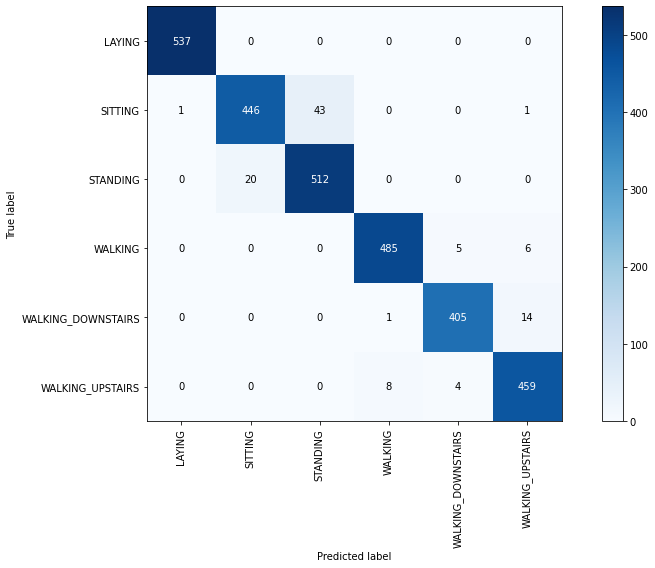

In [ ]:
print("*-*"*40)
print("\n HAR data - SVM Classification on Raw Data\n")
start_tm = process_time()
svm_classifier = svm.SVC(kernel='rbf', C=1000, gamma=0.0001)
print("Training accuracy: ", cross_val_score(
    svm_classifier, X_train, y_train, cv=5).mean())
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

cm_raw_svm = metrics.confusion_matrix(y_test, y_pred)
stop_tm = process_time()
elapsed_tm = stop_tm - start_tm

print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Total Time cost to process SVM model for Raw data: %.2f sec" % (elapsed_tm))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

print("Classification Report:\n", metrics.classification_report(y_test, y_pred))

print("Confusion matrix plot showing\n")
plot_confusion_matrix(cm_raw_svm, labels)
# plt.figure(figsize = (10,7))
# ax = sns.heatmap(cm_raw_svm, annot=True, cmap="YlGnBu")


### SVM Classification on PCA encoded Data


In [ ]:
print("*-*"*40)

print("\n HAR data - SVM Classification on PCA encoded Data\n")
start_tm = process_time()
pca_var = decomposition.PCA(n_components=102, random_state=3)

pca_training = pca_var.fit(X_train)

pca_training.explained_variance_
pca_training.n_components_
X_pca_train = pca_training.transform(X_train)
X_pca_test = pca_training.transform(X_test)


*-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-*

 HAR data - SVM Classification on PCA encoded Data



Train Accuracy: 0.9789175765479543

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Total Time cost to process SVM model for PCA encoded data: 9.35 sec
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       537
           1       0.92      0.91      0.91       491
           2       0.93      0.92      0.93       532
           3       0.97      0.95      0.96       496
           4       0.94      0.93      0.93       420
           5       0.92      0.94      0.93       471

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947

Confusion Matrix plot showing



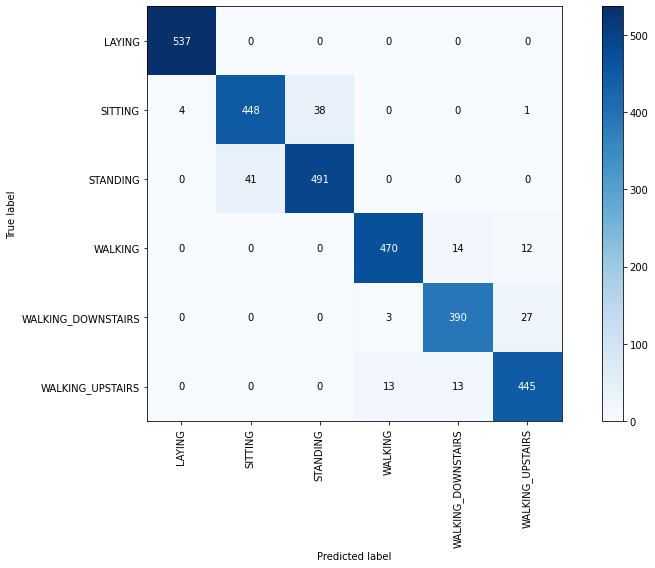

In [ ]:
# Checking Accuracy after applying PCA
svm_classifier = svm.SVC(kernel="rbf", C=1000, gamma=0.001)
# Train Accuracy
print("Train Accuracy:", cross_val_score(
    svm_classifier, X_pca_train, y_train, cv=5).mean())

# Test Accuracy
scv = svm_classifier.fit(X_pca_train, y_train)
y_pred = svm_classifier.predict(X_pca_test)

cm_pca_svm = metrics.confusion_matrix(y_test, y_pred)

stop_tm = process_time()
elapsed_tm = stop_tm - start_tm
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Total Time cost to process SVM model for PCA encoded data: %.2f sec" % (elapsed_tm))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
print("Classification Report:\n", metrics.classification_report(y_test, y_pred))

print("Confusion Matrix plot showing\n")
plot_confusion_matrix(cm_pca_svm, labels)


### SVM Classification on FLDA encoded Data


In [ ]:
print("*-*"*40)
print("\n HAR data - SVM Classification on FLDA encoded Data\n")
start_tm = process_time()

lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=5)
tr_class = y_train[:, np.newaxis]
lda_fit = lda.fit(X_train, y_train)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.fit_transform(X_test, y_test)


*-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-*

 HAR data - SVM Classification on FLDA encoded Data




~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Total Time cost to process SVM model for FLDA encoded data: 12.36 sec
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       537
           1       0.92      0.91      0.91       491
           2       0.93      0.92      0.93       532
           3       0.97      0.95      0.96       496
           4       0.94      0.93      0.93       420
           5       0.92      0.94      0.93       471

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947

Confusion matrix plot showing



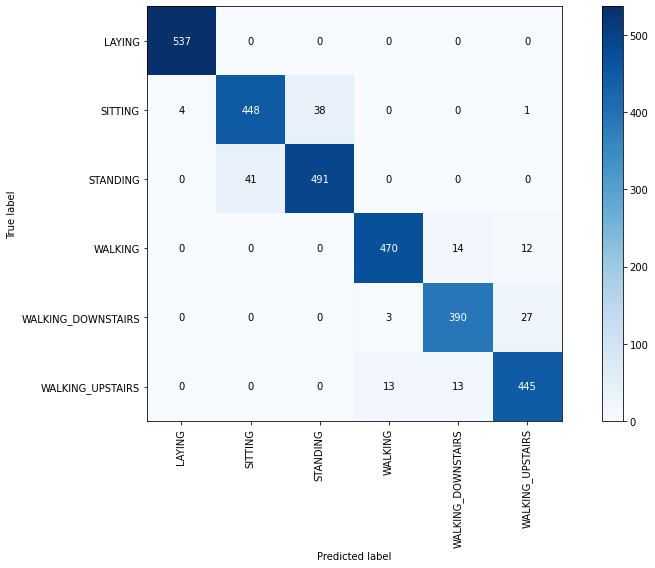

In [ ]:
lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=5)
tr_class = y_train[:, np.newaxis]
lda_fit = lda.fit(X_train, y_train)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.fit_transform(X_test, y_test)

cm_lda_svm = metrics.confusion_matrix(y_test, y_pred)

stop_tm = process_time()
elapsed_tm = stop_tm - start_tm
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Total Time cost to process SVM model for FLDA encoded data: %.2f sec" % (elapsed_tm))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

print("Classification Report:\n", metrics.classification_report(y_test, y_pred))
print("Confusion matrix plot showing\n")
plot_confusion_matrix(cm_lda_svm, labels)


In [ ]:
print("*-*"*40)
print("\n HAR data - SVM Classification on FLDA-fromscratch encoded Data\n")
start_tm = process_time()

train_data = np.insert(X_train, 561, y_train, axis=1)
test_data = np.insert(X_test, 561, y_test, axis=1)

train_FLDA = Fisher(train_data, 5)
test_FLDA = np.real(train_FLDA.eigvals.dot(X_test.T))


*-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-*

 HAR data - SVM Classification on FLDA-fromscratch encoded Data




~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Total Time cost to process SVM model for FLDA-from-scratch encoded data: 23.24 sec
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.93       537
           1       0.72      0.88      0.79       491
           2       0.86      0.78      0.82       532
           3       0.91      0.61      0.73       496
           4       0.68      0.78      0.73       420
           5       0.64      0.73      0.68       471

    accuracy                           0.78      2947
   macro avg       0.80      0.78      0.78      2947
weighted avg       0.80      0.78      0.79      2947

Confusion matrix plot showing



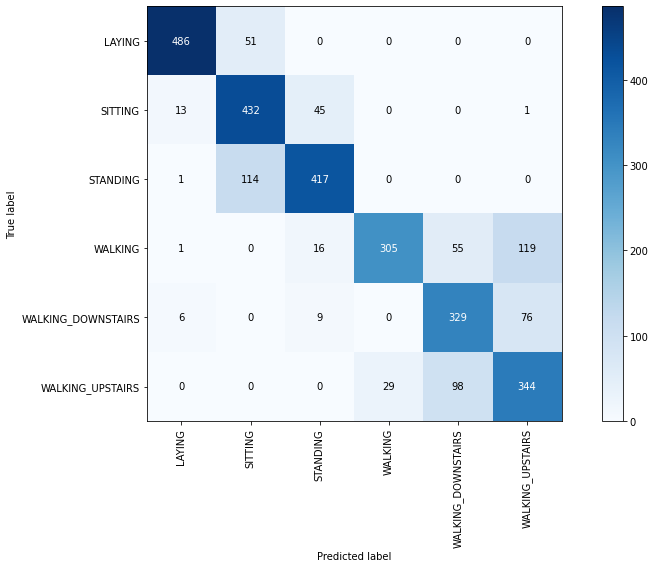

In [ ]:
train_data = np.asarray(train_FLDA.tf_data)
test_data = np.asarray(test_FLDA)

svm_classifier = svm.SVC(kernel='rbf', C=0.1)
svm_classifier.fit(train_data[:, 1:], train_data[:, 0])
y_pred = svm_classifier.predict(test_data.T)

cm_flda_svm = metrics.confusion_matrix(y_test, y_pred)

stop_tm = process_time()
elapsed_tm = stop_tm - start_tm
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Total Time cost to process SVM model for FLDA-from-scratch encoded data: %.2f sec" % (elapsed_tm))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

print("Classification Report:\n", metrics.classification_report(y_test, y_pred))

print("Confusion matrix plot showing\n")
plot_confusion_matrix(cm_flda_svm, labels)


## CNN Implementation


### CNN For Raw Data


In [ ]:
print("*-*"*40)
print("\n HAR data - CNN Classification on Raw Data\n")
start_tm = process_time()

X_train_sp, x_val, y_train_sp, y_val = train_test_split(
    X_train, y_train_enc, test_size=.15)
print((X_train_sp.shape, y_train_sp.shape))
print((x_val.shape, y_val.shape))
print((X_test.shape, y_test.shape))


*-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-*

 HAR data - CNN Classification on Raw Data

((6249, 561), (6249, 6))
((1103, 561), (1103, 6))
((2947, 561), (2947,))


In [ ]:
epochs, batch_size = 30, 128
X_train_CNN = np.expand_dims(X_train, axis=2)
X_val_CNN = np.expand_dims(x_val, axis=2)
X_test_CNN = np.expand_dims(X_test, axis=2)
n_timesteps, n_features, n_outputs = X_train_CNN.shape[
    1], X_train_CNN.shape[2], y_train_enc.shape[1]
X_train_CNN.shape


(7352, 561, 1)

In [ ]:
model = tfkeras.Sequential()
model.add(Conv1D(filters=64, kernel_size=7, activation='relu',
          input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', name="SVM_input"))
model.add(Dense(n_outputs, activation='softmax'))


relr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.01,
                                            patience=2, min_lr=1e-5)

adam = tfkeras.optimizers.Adam(lr=.00025)


model.compile(loss='categorical_crossentropy',
              optimizer=adam, metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 555, 64)           512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 549, 64)           28736     
_________________________________________________________________
dropout (Dropout)            (None, 549, 64)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 274, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 17536)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               8978944   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)              

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(X_train_CNN, y_train_enc, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val_CNN, y_val),
                    callbacks=[relr])


Epoch 1/30
58/58 [==============================] - 31s 38ms/step - loss: 0.7494 - accuracy: 0.6964 - val_loss: 0.6118 - val_accuracy: 0.9148
Epoch 2/30
58/58 [==============================] - 2s 30ms/step - loss: 0.2516 - accuracy: 0.9072 - val_loss: 0.3789 - val_accuracy: 0.9565
Epoch 3/30
58/58 [==============================] - 2s 31ms/step - loss: 0.1365 - accuracy: 0.9495 - val_loss: 0.2179 - val_accuracy: 0.9692
Epoch 4/30
58/58 [==============================] - 2s 30ms/step - loss: 0.1058 - accuracy: 0.9611 - val_loss: 0.1237 - val_accuracy: 0.9873
Epoch 5/30
58/58 [==============================] - 2s 30ms/step - loss: 0.0874 - accuracy: 0.9668 - val_loss: 0.0608 - val_accuracy: 0.9864
Epoch 6/30
58/58 [==============================] - 2s 29ms/step - loss: 0.0706 - accuracy: 0.9767 - val_loss: 0.0443 - val_accuracy: 0.9900
Epoch 7/30
58/58 [==============================] - 2s 30ms/step - loss: 0.0588 - accuracy: 0.9799 - val_loss: 0.0321 - val_accuracy: 0.9927
Epoch 8/30
5

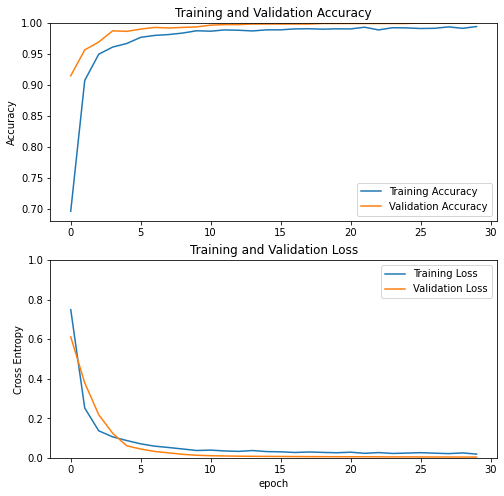

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
# evaluate model
_, CNN_accuracy = model.evaluate(
    X_test_CNN, y_test_enc, batch_size=batch_size, verbose=1)
CNN_accuracy


24/24 [==============================] - 0s 11ms/step - loss: 0.1271 - accuracy: 0.9617


0.9616559147834778


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Total Time cost to process CNN model for Raw data: 46.62 sec
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       537
           1       0.94      0.91      0.93       491
           2       0.93      0.95      0.94       532
           3       0.98      0.98      0.98       496
           4       0.99      0.94      0.96       420
           5       0.94      0.98      0.96       471

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947

Confusion matrix plot showing



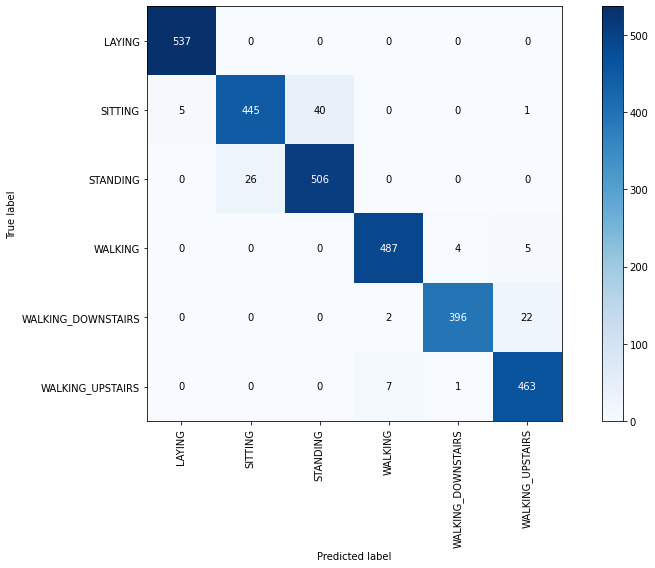

In [ ]:
y_CNN_pred = model.predict(X_test_CNN)
cm_raw_cnn = metrics.confusion_matrix(
    y_test_enc.argmax(axis=1), y_CNN_pred.argmax(axis=1))

stop_tm = process_time()
elapsed_tm = stop_tm - start_tm
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Total Time cost to process CNN model for Raw data: %.2f sec" % (elapsed_tm))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

print("Classification Report:\n", metrics.classification_report(
    y_test_enc.argmax(axis=1), y_CNN_pred.argmax(axis=1)))

print("Confusion matrix plot showing\n")
plot_confusion_matrix(cm_raw_cnn, labels)


### CNN + SVM


Feeding CNN model penultimate layer output to SVM


In [ ]:
print("*-*"*40)
print("\n HAR data - CNN+SVM Classification on Raw Data\n")

model_feat = tfkeras.models.Model(
    inputs=model.input, outputs=model.get_layer('SVM_input').output)
X_train_fit = np.expand_dims(X_train, axis=2)
feat_train = model_feat.predict(X_train_fit)
print("\nShape of train deep feature from CNN: ", feat_train.shape)

feat_test = model_feat.predict(X_test_CNN)
print("\nShape of test deep feature from CNN: ", feat_test.shape)


*-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-*

 HAR data - CNN+SVM Classification on Raw Data


Shape of train deep feature from CNN:  (7352, 128)

Shape of test deep feature from CNN:  (2947, 128)


In [ ]:
svm_classifier = svm.SVC(kernel="rbf", C=1000, gamma=0.001)
# Train Accuracy
print("Train Accuracy:", cross_val_score(svm_classifier,
      feat_train, y_train, cv=KFold(n_splits=5)).mean())

# Test Accuracy
scv = svm_classifier.fit(feat_train, y_train)
y_pred = svm_classifier.predict(feat_test)
print("Test Accuracy:", metrics.accuracy_score(y_pred, y_test))

stop_tm = process_time()
elapsed_tm = stop_tm - start_tm
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Total Time cost to process CNN+SVM model for Raw data: %.2f sec" %
      (elapsed_tm))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

print("Classification Report:\n", metrics.classification_report(y_test, y_pred))


Train Accuracy: 0.9989118420991783
Test Accuracy: 0.9602986087546658

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Total Time cost to process CNN+SVM model for Raw data: 48.77 sec
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.95      0.91      0.93       491
           2       0.93      0.95      0.94       532
           3       0.98      0.97      0.98       496
           4       0.98      0.94      0.96       420
           5       0.94      0.98      0.96       471

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



### CNN with PCA data


In [ ]:
print("*-*"*40)
print("\n HAR data - CNN Classification on PCA encoded Data\n")
start_tm = process_time()

X_train_sp_pca, x_val_pca, y_train_sp_pca, y_val_pca = train_test_split(
    X_pca_train, y_train_enc, test_size=.15)
print((X_train_sp_pca.shape, y_train_sp_pca.shape))
print((x_val_pca.shape, y_val_pca.shape))
print((X_pca_test.shape, y_test.shape))


*-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-*

 HAR data - CNN Classification on PCA encoded Data

((6249, 102), (6249, 6))
((1103, 102), (1103, 6))
((2947, 102), (2947,))


In [ ]:
epochs, batch_size = 30, 128
X_train_CNN_pca = np.expand_dims(X_pca_train, axis=2)
X_val_CNN_pca = np.expand_dims(x_val_pca, axis=2)
X_test_CNN_pca = np.expand_dims(X_pca_test, axis=2)
n_timesteps_pca, n_features_pca, n_outputs_pca = X_train_CNN_pca.shape[
    1], X_train_CNN_pca.shape[2], y_train_enc.shape[1]
X_train_CNN_pca.shape


(7352, 102, 1)

In [ ]:
model_PCA = tfkeras.Sequential()
model_PCA.add(Conv1D(filters=64, kernel_size=7, activation='relu',
              input_shape=(n_timesteps_pca, n_features_pca)))
model_PCA.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
model_PCA.add(Dropout(0.5))
model_PCA.add(MaxPooling1D(pool_size=2))
model_PCA.add(Flatten())
model_PCA.add(Dense(512, activation='relu'))
model_PCA.add(Dropout(0.5))
model_PCA.add(BatchNormalization())
model_PCA.add(Dense(256, activation='relu'))
model_PCA.add(Dropout(0.5))
model_PCA.add(Dense(128, activation='relu', name="SVM_PCA_input"))
model_PCA.add(Dense(n_outputs_pca, activation='softmax'))

relr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.01,
                                            patience=2, min_lr=1e-5)

adam = tfkeras.optimizers.Adam(lr=.00025)

model_PCA.compile(loss='categorical_crossentropy',
                  optimizer=adam, metrics=['accuracy'])
model_PCA.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 96, 64)            512       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 90, 64)            28736     
_________________________________________________________________
dropout_3 (Dropout)          (None, 90, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 45, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2880)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               1475072   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)              

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history_PCA = model_PCA.fit(X_train_CNN_pca, y_train_enc, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val_CNN_pca, y_val_pca),
                            callbacks=[relr])


Epoch 1/30
58/58 [==============================] - 3s 19ms/step - loss: 1.7136 - accuracy: 0.3126 - val_loss: 1.5634 - val_accuracy: 0.6310
Epoch 2/30
58/58 [==============================] - 1s 11ms/step - loss: 1.0426 - accuracy: 0.6055 - val_loss: 0.9789 - val_accuracy: 0.8794
Epoch 3/30
58/58 [==============================] - 1s 11ms/step - loss: 0.6075 - accuracy: 0.7686 - val_loss: 0.5646 - val_accuracy: 0.8876
Epoch 4/30
58/58 [==============================] - 1s 10ms/step - loss: 0.4347 - accuracy: 0.8346 - val_loss: 0.3273 - val_accuracy: 0.9302
Epoch 5/30
58/58 [==============================] - 1s 10ms/step - loss: 0.3476 - accuracy: 0.8700 - val_loss: 0.2116 - val_accuracy: 0.9538
Epoch 6/30
58/58 [==============================] - 1s 10ms/step - loss: 0.2826 - accuracy: 0.8930 - val_loss: 0.1711 - val_accuracy: 0.9483
Epoch 7/30
58/58 [==============================] - 1s 11ms/step - loss: 0.2577 - accuracy: 0.8998 - val_loss: 0.1214 - val_accuracy: 0.9637
Epoch 8/30
58

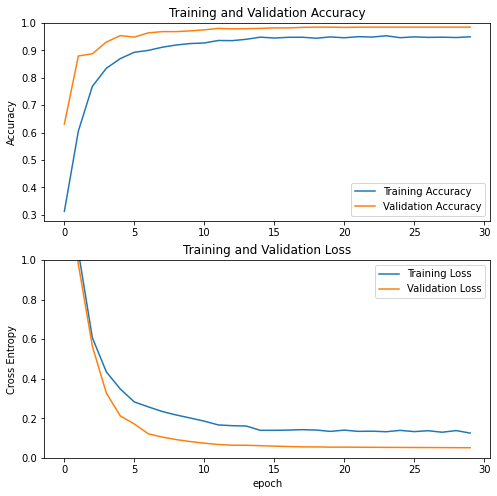

In [ ]:
acc = history_PCA.history['accuracy']
val_acc = history_PCA.history['val_accuracy']

loss = history_PCA.history['loss']
val_loss = history_PCA.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
# evaluate model
_, CNN_PCA_accuracy = model_PCA.evaluate(
    X_test_CNN_pca, y_test_enc, batch_size=batch_size, verbose=1)
CNN_PCA_accuracy


24/24 [==============================] - 0s 6ms/step - loss: 0.2040 - accuracy: 0.9284


0.92840176820755


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Total Time cost to process CNN model for PCA encoded data: 21.98 sec
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       537
           1       0.88      0.91      0.89       491
           2       0.92      0.89      0.90       532
           3       0.92      0.96      0.94       496
           4       0.96      0.85      0.91       420
           5       0.90      0.95      0.92       471

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947

Confusion matrix plot showing



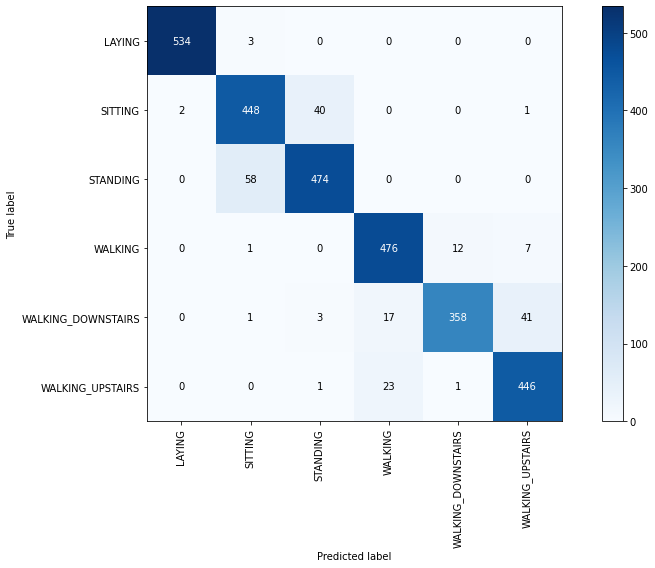

In [ ]:
y_PCA_CNN_pred = model_PCA.predict(X_test_CNN_pca)


stop_tm = process_time()
elapsed_tm = stop_tm - start_tm
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Total Time cost to process CNN model for PCA encoded data: %.2f sec" % (elapsed_tm))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

print("Classification Report:\n", metrics.classification_report(
    y_test_enc.argmax(axis=1), y_PCA_CNN_pred.argmax(axis=1)))

print("Confusion matrix plot showing\n")

cm_pca_cnn = metrics.confusion_matrix(
    y_test_enc.argmax(axis=1), y_PCA_CNN_pred.argmax(axis=1))
plot_confusion_matrix(cm_pca_cnn, labels)


### CNN + SVM with PCA data


In [ ]:
print("*-*"*40)
print("\n HAR data - CNN+SVM Classification on PCA encoded Data\n")

model_feat_PCA = tfkeras.models.Model(
    inputs=model_PCA.input, outputs=model_PCA.get_layer('SVM_PCA_input').output)
X_train_fit_PCA = np.expand_dims(X_pca_train, axis=2)
feat_train_PCA = model_feat_PCA.predict(X_train_fit_PCA)
print("\nShape of train deep feature from CNN: ", feat_train_PCA.shape)

feat_test_PCA = model_feat_PCA.predict(X_test_CNN_pca)
print("\nShape of test deep feature from CNN: ", feat_test.shape)


*-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-*

 HAR data - CNN+SVM Classification on PCA encoded Data


Shape of train deep feature from CNN:  (7352, 128)

Shape of test deep feature from CNN:  (2947, 128)


In [ ]:
svm_classifier_PCA = svm.SVC(kernel="rbf", C=1000, gamma=0.001)
# Train Accuracy
print("Train Accuracy:", cross_val_score(svm_classifier_PCA,
      feat_train_PCA, y_train, cv=KFold(n_splits=5)).mean())

# Test Accuracy
scv = svm_classifier_PCA.fit(feat_train_PCA, y_train)
y_pred = svm_classifier_PCA.predict(feat_test_PCA)


print("Test Accuracy:", metrics.accuracy_score(y_pred, y_test))

stop_tm = process_time()
elapsed_tm = stop_tm - start_tm
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Total Time cost to process CNN+SVM model for PCA encoded data: %.2f sec" % (elapsed_tm))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

print("Classification Report:\n", metrics.classification_report(y_test, y_pred))


Train Accuracy: 0.9815016856504668
Test Accuracy: 0.9321343739395996

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Total Time cost to process CNN+SVM model for PCA encoded data: 25.47 sec
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.89      0.89      0.89       491
           2       0.90      0.90      0.90       532
           3       0.95      0.92      0.93       496
           4       0.94      0.93      0.93       420
           5       0.92      0.96      0.94       471

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



## Simple Neural Network Implementation


Using simple neural network as data transformed with LDA is not enough to train a CNN. Using a simple neural network with dense hidden layers allows our model to be able to run with small feature set but provides great accuracy


NN for FLDA data


In [ ]:
print("*-*"*40)
print("\n HAR data - DNN Classification on FLDA encoded Data\n")
start_tm = process_time()

model_NN = Sequential([
    Dense(16, activation='relu', input_shape=(5,)),
    Dense(16, activation='relu', name="SVM_LDA_input"),
    Dense(6, activation='softmax'),
])

Adam_opt = tfkeras.optimizers.Adam(
    lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# Compile the model
model_NN.compile(
    optimizer=Adam_opt,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model_NN.summary()

# Train the model
model_NN.fit(
    X_train_lda,
    to_categorical(y_train),
    validation_split=0.33,
    epochs=30,
    batch_size=32,
)


*-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-*

 HAR data - DNN Classification on FLDA encoded Data

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 16)                96        
_________________________________________________________________
SVM_LDA_input (Dense)        (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 102       
Total params: 470
Trainable params: 470
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


154/154 [==============================] - 1s 6ms/step - loss: 0.7854 - accuracy: 0.8045 - val_loss: 0.1697 - val_accuracy: 0.9806
Epoch 2/30
154/154 [==============================] - 1s 5ms/step - loss: 0.1027 - accuracy: 0.9829 - val_loss: 0.0686 - val_accuracy: 0.9839
Epoch 3/30
154/154 [==============================] - 1s 5ms/step - loss: 0.0555 - accuracy: 0.9850 - val_loss: 0.0531 - val_accuracy: 0.9848
Epoch 4/30
154/154 [==============================] - 1s 4ms/step - loss: 0.0443 - accuracy: 0.9854 - val_loss: 0.0473 - val_accuracy: 0.9839
Epoch 5/30
154/154 [==============================] - 1s 4ms/step - loss: 0.0402 - accuracy: 0.9862 - val_loss: 0.0429 - val_accuracy: 0.9868
Epoch 6/30
154/154 [==============================] - 1s 4ms/step - loss: 0.0385 - accuracy: 0.9860 - val_loss: 0.0421 - val_accuracy: 0.9856
Epoch 7/30
154/154 [==============================] - 1s 5ms/step - loss: 0.0372 - accuracy: 0.9860 - val_loss: 0.0407 - val_accuracy: 0.9872
Epoch 8/30
154/15

In [ ]:
model_NN.save('LDA_NN.h5')


In [ ]:
model_NN.evaluate(
    X_test_lda,
    to_categorical(y_test)
)


93/93 [==============================] - 0s 3ms/step - loss: 0.0626 - accuracy: 0.9766


[0.06261806190013885, 0.9765863418579102]

Confusion Matrix for NN with FLDA



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Total Time cost to process DNN model for FLDA encoded data: 26.18 sec
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.98      0.97      0.98       491
           2       0.98      0.98      0.98       532
           3       1.00      1.00      1.00       496
           4       0.90      1.00      0.95       420
           5       1.00      0.90      0.95       471

    accuracy                           0.98      2947
   macro avg       0.98      0.98      0.98      2947
weighted avg       0.98      0.98      0.98      2947

Confusion matrix plot showing



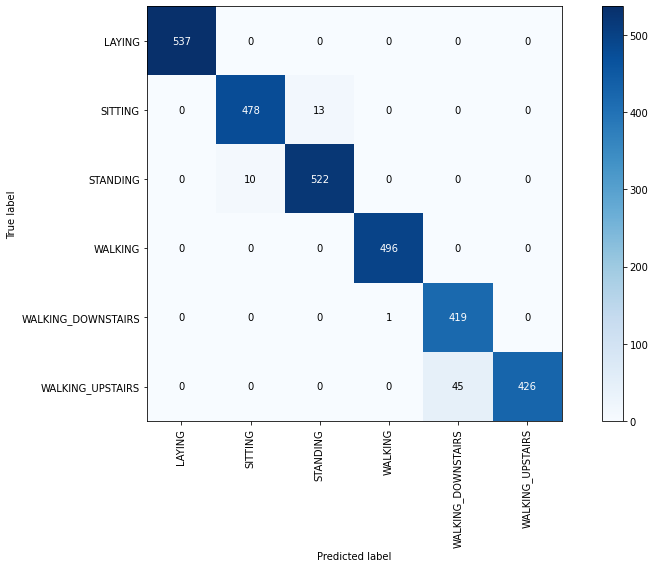

In [ ]:
y_NN_pred = model_NN.predict(X_test_lda)

stop_tm = process_time()
elapsed_tm = stop_tm - start_tm
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Total Time cost to process DNN model for FLDA encoded data: %.2f sec" % (elapsed_tm))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

print("Classification Report:\n", metrics.classification_report(
    y_test, y_NN_pred.argmax(axis=1)))

print("Confusion matrix plot showing\n")
cm_raw_nn = metrics.confusion_matrix(y_test, y_NN_pred.argmax(axis=1))
plot_confusion_matrix(cm_raw_nn, labels)
plt.savefig("conf_mat.png")


### NN + SVM for LDA data


In [ ]:
print("*-*"*40)
print("\n HAR data - DNN+SVM Classification on FLDA encoded Data\n")

model_feat_NN = tfkeras.models.Model(
    inputs=model_NN.input, outputs=model_NN.get_layer('SVM_LDA_input').output)

feat_train_NN = model_feat_NN.predict(X_train_lda)
print("\nShape of train deep feature from DNN: ", feat_train_NN.shape)

feat_test_NN = model_feat_NN.predict(X_test_lda)
print("\nShape of test deep feature from DNN: ", feat_test_NN.shape)


*-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-*

 HAR data - DNN+SVM Classification on FLDA encoded Data


Shape of train deep feature from DNN:  (7352, 16)

Shape of test deep feature from DNN:  (2947, 16)


In [ ]:
svm_NN_classifier = svm.SVC(kernel="rbf", C=1000, gamma=0.001)
# Train Accuracy
print("Train Accuracy:", cross_val_score(svm_NN_classifier,
      feat_train_NN, y_train, cv=KFold(n_splits=5)).mean())

# Test Accuracy
scv = svm_NN_classifier.fit(feat_train_NN, y_train)
y_pred_NN = svm_NN_classifier.predict(feat_test_NN)
# ac_score = metrics.accuracy_score(y_pred, df_testlabel)
print("Test Accuracy:", metrics.accuracy_score(y_pred_NN, y_test))

stop_tm = process_time()
elapsed_tm = stop_tm - start_tm
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Total Time cost to process CNN+SVM model for PCA encoded data: %.2f sec" % (elapsed_tm))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

print("Classification Report:\n", metrics.classification_report(y_pred_NN, y_test))


Train Accuracy: 0.9865344968714883
Test Accuracy: 0.9809976247030879

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Total Time cost to process CNN+SVM model for PCA encoded data: 20.69 sec
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.95      1.00      0.97       466
           2       1.00      0.95      0.98       557
           3       1.00      1.00      1.00       497
           4       1.00      0.94      0.97       447
           5       0.94      1.00      0.97       443

    accuracy                           0.98      2947
   macro avg       0.98      0.98      0.98      2947
weighted avg       0.98      0.98      0.98      2947

